# GNN GCN Explainer

The goal of this notebook is to walk through Graph Convolutional Networks (GCNs) flavor of a GNN (graph neural network). Like CNNs on images, GCNs operate on graphs where nodes are entities  and edges encode relations. A standard GCN layer does two things: it aggregates normalized messages from each node’s neighbors (using the graph’s adjacency) and mixes features with a shared linear transform. Stacking more layers lets information flow across more hops (think 2 connections apart). This makes GCNs effective for node classification, link prediction, and graph classification. In this notebook we'll actually focus on a specific variant called a signed GCNs since it allows for edges to have both positive and negative relationships while keeping the same message-passing idea. Common GNN pitfalls include over-smoothing through the use of deep layers that make nodes look alike, over-squashing that creates long-range info bottlenecked, and numerical issues on irregular/signed graphs. We'll address some fixes to these in our examples. 

To help display how GCNs work, we'll use a representation of a gene regulatory network where we have 2 specific cell types, a set of genes that are up/down regulated, and then a label for each sample to flag if it's cancerous or not. With our GCN, the goal will be to train it to take in a set of genes and how they're regulated and then predict the cell type as the *node task*, or node level prediction and whether it's cancerous as the *graph task* or graph level prediction. This dual goal will require us to balance 2 loss functions. 

## Graph Data Prep

We'll start with a common preprocessing step. Instead of a typical tokenizer, we have to create a numerical representation of our graph by enumerating the nodes and edges. This process first starts by creating a series of "token-like" IDS for our node vocabulary. In our example that becomes the gene and cell types.  We then use integers to map the relationship of the gene and cell types. This is where our **signed graph** starts since we use `+1` edges for up-regulation and `-1` for down-regulation.   As a result we end up with the following generated:
1. **x_tokens** - a list of nodes
2. **y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample if the gene is more common with B-cells or T-cells.  We use a `-1` here to flag cells to ignore
3. **y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign
4. **a_list** - the nodes in our graph that link the different cell types and genes together.  We pool all the samples together into a large block-diagonal matrix.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
cell_types = ["Tcells","Bcells"]
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [3]:
benign = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19'],'down': ['CD3D','LCK','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_2 = {
    'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
    'Bcells':{'up': ['CD19','CD3D'],'down': ['LCK','ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_3 = {
    'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

In [4]:
def build_vocab(genes, cell_types):
    toks = genes + [f"CT_{ct}" for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [5]:
def make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi):
    N = len(node_order)
    A = torch.zeros(N, N)
    def idx(n): return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A[i,j] = s; A[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): add_edge(g, ct, -1)
    X_tokens = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    y_node = torch.full((N,), -1, dtype=torch.long)   # -1 = ignore (CT nodes)
    # per-gene cell-type label: 0=Tcells, 1=Bcells; rule: prefer UP; tie-break by order T then B; fallback from DOWN (invert)
    for g in genes:
        def score(ct):
            rel = spec.get(ct, {})
            return int(g in rel.get('up', [])) - int(g in rel.get('down', []))
        t_score = score('Tcells')
        b_score = score('Bcells')
        i = idx(g)
        if t_score > b_score: y_node[i] = 0            # T
        elif b_score > t_score: y_node[i] = 1          # B
        else:
            # option (a) ignore ties/no-signal:
            # y_node[i] = -1
            # option (b) deterministic tie-break to T:
            y_node[i] = 0
    return X_tokens, y_node, A

In [6]:
graphs = [benign, cancerous, cancerous_2, cancerous_3]
x_list, y_node_list, a_list = [], [], []

In [7]:
for spec in graphs:
    x_i, y_i, a_i = make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi)
    x_list.append(x_i); y_node_list.append(y_i); a_list.append(a_i.float())

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [8]:
x_tokens = torch.stack(x_list)   
x_tokens.size(), x_tokens

(torch.Size([4, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [9]:
y_node   = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign

In [10]:
y_graph  = torch.tensor([0,1,1,1]) # 0=benign, 1=cancerous
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**Graph** 

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

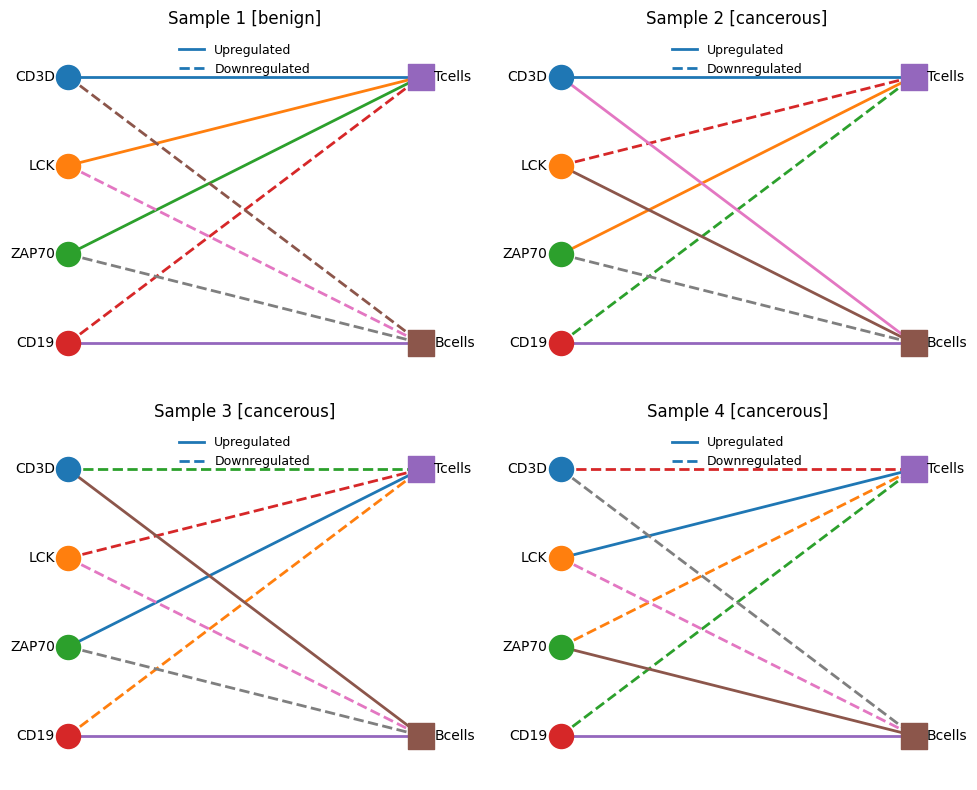

In [11]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
samples = [
    ('Sample 1 [benign]',    benign),
    ('Sample 2 [cancerous]',    cancerous),
    ('Sample 3 [cancerous]',  cancerous_2),
    ('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, we'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of nodes that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case you'll notice that each example contains all the nodes. 

In [12]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(4,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [13]:
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]))

**y_graph** - per-graph label to determine if an example is cancerous. `0` is for benign and `1` is for cancerous.  

In [14]:
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**A_list** - The relationships for each of our cells.  You'll notice here that only the last two rows and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to suppress the gene x gene portions of the matrix. 

In [15]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1.,  

### Data Loading - Signed Symmetric Graph Normalization

With `a_list` we now have all of our relationships but they're not in the most training conducive structure.  For our training, since we actually have 2 types of relationships, we need to split that into two different graphs that the model can learn across. This split creates 2 channels, 1 for the excitatory regulation, and one for the inhibitory.  We then run normalization, and a self-loop on the excitatory, to improve numerical stability, scaling, and preserve node signals to themself. Finally, once we've split and normalized each of the samples, we'll combine all of the same-signed tensors together into 1 large one using block-diagnola (which basically puts the graphs iteratively one after another diagonally into one big tensor).  

Symmetric degree normalization bounds the propagation operator and removes degree bias. the split $A^{+}/A^{-}$ prevents destructive cancellation by a model trying to learn up and down regulation together, and lets the model learn different filters for up- vs down-regulation, self-loops in the positive channel allow each node to retain its identity. Finally block-diagonal stacking gives clean batching without cross-graph leakage. Fundamentally we apply:

$$
\tilde A = D^{-\tfrac12},\hat A,D^{-\tfrac12} \newline
\text{so}\\
\quad w_{ij}=\frac{\hat A_{ij}}{\sqrt{\deg_i,\deg_j}}.
$$

#### Signed Symmetric Graph Norm - First Example

Let's start with our first example. This one is our benign.  The first step is to extract the network from the list.  

In [16]:
A = a_list[0]
A.size(), A

(torch.Size([6, 6]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  1., -1.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.]]))

**Splitting** 

Now we'll split the network into the two different tensors, one for the positives and one for the negatives.  Recall that 0s are non-information for our training so we do not care where they go. 

In [17]:
A_pos = torch.clamp(A, min=0)  
A_neg = torch.clamp(-A, min=0)  
A_pos, A_neg

(tensor([[0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 0., -0., -0.]]))

**Self loop**

We'll now add the self-loop in. Adding a self-loop lets each node pass some of its own features forward, so its identity isn’t washed out by neighbors, especially when it has few or noisy connections. It acts like a tiny skip connection, stabilizing message passing and improving learning and gradient flow. We do need to be careful though to only include it in one split. If we put the self-loop in both channels, when we do our subtraction during our forward pass, we'd add, then subtract a copy of the node’s own features every pass, which fights the residual/identity signal, shrinks or flips activations, and destabilizes training.

In [18]:
I = torch.eye(N_nodes)
A_pos_hat = A_pos + I # add for self looops 
A_neg_hat = A_neg
A_pos_hat, A_neg_hat

(tensor([[1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.],
         [1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.]]),
 tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 0., -0., -0.]]))

**Degree scaling**

As part of our normalization we divide by the square root of the product of the row and column sums.  We'll also add in a small epsilon to make sure we're not dividing by 0. We'll take this sum by graph then take the square roots. After that we'll create a diagonal so that we can take the dot product instead of having to worry about dimensions. 

In [19]:
deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
deg_pos, deg_neg

(tensor([2., 2., 2., 2., 4., 2.]), tensor([1., 1., 1., 1., 1., 3.]))

In [20]:
D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
D_pos_inv_sqrt, D_neg_inv_sqrt

(tensor([[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071]]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774]]))

**Normalization**

Finally we'll do our normalization through our dot prod of the network with our inverse square root. 

In [21]:
Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
Apos_n, Aneg_n

(tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.5774, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000]]))

**Bulk prep** 

Since we have 3 other samples to process, we'll create a list for aggregating the other normalizations and add these into them. 

In [22]:
Apos_blk, Aneg_blk = [], []
Apos_blk.append(Apos_n)
Aneg_blk.append(Aneg_n)

#### Signed Symmetric Graph Norm - Remaining Example

Now that we've stepped through the first example, we'll do the same for the remaining three examples.  At the end we'll have normalized entries for all the examples split by sign. 

In [23]:
for A in a_list[1:]:
    A_pos = torch.clamp(A, min=0)  
    A_neg = torch.clamp(-A, min=0)  
    I = torch.eye(N_nodes)
    A_pos_hat = A_pos + I
    A_neg_hat = A_neg
    deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
    deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
    D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
    D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
    Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
    Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
    Apos_blk.append(Apos_n)
    Aneg_blk.append(Aneg_n)

In [24]:
Apos_blk

[tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.2887],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.4082, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.3536],
         [0.3333, 0.0000, 0.4082, 0.0000, 0.3333, 0.0000],
         [0.2887, 0.3536, 0.0000, 0.3536, 0.0000, 0.2500]]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4082],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.4082],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.

In [25]:
Aneg_blk

[tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.5774, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.4082, 0.5000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000],
         [0.5774, 0.4082, 0.0000, 0.5774, 0.0000, 0.

#### Signed Symmetric Graph Norm - Block Diagonal

As our final step, we now join our networks together. We do this using a block diagonal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our case this results in a `[24,24]` matrix since we have 4 examples with 6 nodes. 

In [26]:
Apos_blk =  torch.block_diag(*Apos_blk)
Apos_blk.size(), Apos_blk

(torch.Size([24, 24]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
   

In [27]:
Aneg_blk =  torch.block_diag(*Aneg_blk)
Aneg_blk.size(), Aneg_blk

(torch.Size([24, 24]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
   

## Forward pass

<img src="explainer_screenshots/gcn/full_network.png" width="300">

During training, in the GCN we've built, the forward pass takes in the set of nodes per example and a signed network map and uses this to predict the cell type by node and the cancerous level of the graph. This is quite different from other models we've explored where we're doing things like next token prediction. An additional difference here is that our "batch" and "token" dimensions are one in the same, being that we just have 1 dimension to signify our examples, which we'll call batch.  We could layer in batch based learning but it would make things super complicated. 

Our walkthrough of the forward pass is focused on training where we'll pass in the input nodes `x_tokens` and signed graph `Apos_blk, Aneg_blk`, carry that input through the layers, and generate 2 matrices of the probability for the node and graph level prediction. These predictions will be two different sets of `logits`. During the forward pass, after embedding our input nodes we'll pass through two different graph convolutions to help learn our two hops in the graph while including in common normalization and residual steps. 

At the end of the forward pass we then compare the probability in the logits to the actual next token in `y_node, y_graph` and calculate `loss` based on the difference. You'll see that we calculate the loss on each head, then sum it for a final loss (and so that we can distribute across both pathways in backprop). This difference is what we'll then use in the backprop/training steps.  

*Note that we will do some layer initialization to simplify following along.  In reality, layers are often initialized to normal distribution with some adjustments made for parameter sizes, called Kaiming normal, to keep the weights properly noisy.  We will not cover initialization in this series*

### Input Layer - Embedding projection

<img src="explainer_screenshots/gcn/input_layer.png" width="400">

We'll first create an initial **embedding layer** for our sample level node tokens. Recall that this is the layer that will add the second dimension to our node list. We start with supplying only the nodes. In parallel our network graphs will also be kept on the side as they'll be inputs to the next layer. Generally, by using an embedding on the node, we give the graph a chance to learn how important the different nodes are per example and how to use them, and the node order, in our output prediction task.  We'll also use a small embedding dimension to allow the network to learn a deeper representation of our nodes. After doing the embedding, we'll then remove our batch dimensions for the remaining training to simplify our training.  

We'll start by initializing the weight to a sliding scale so that we can quickly see each layer's impact. 

In [28]:
n_embd = 3 # level of embedding of input tokens
vocab_size, n_embd

(6, 3)

In [29]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = tok_emb.num_embeddings, tok_emb.embedding_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight

Parameter containing:
tensor([[0.0010, 0.0020, 0.0030],
        [0.0020, 0.0030, 0.0040],
        [0.0030, 0.0040, 0.0050],
        [0.0040, 0.0050, 0.0060],
        [0.0050, 0.0060, 0.0070],
        [0.0060, 0.0070, 0.0080]], requires_grad=True)

**Embedding projection**

Remember that each of our samples includes all the nodes so we expect that all the weights will be used repeatedly for each sample.  

In [30]:
x = tok_emb(x_tokens)
x

tensor([[[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080]],

        [[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080]],

        [[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080]],

        [[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080]]], grad_fn=<EmbeddingBackward0>)

**Collapse the batch**

Now we'll remove the batch for further training and learning. If you recall we combined our networks using blocked diagonal so the batch removal now aligns the "sample"/"node" dimension  with the dimension in the network tensor. 

In [31]:
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080],
         [0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080],
         [0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080],
         [0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040],
         [0.0030, 0.0040, 0.0050],
         [0.0040, 0.0050, 0.0060],
         [0.0050, 0.0060, 0.0070],
         [0.0060, 0.0070, 0.0080]], grad_fn=<ViewBackward0>))

### GCN Block

<img src="explainer_screenshots/gcn/block_details.png" width="400">


To support our two hops of learning (Cell type > gene > cell type) we stack two signed graph-convolution layers with normalization and nonlinearity to learn increasingly expressive node features. As a reminder, we have split our edges into two different graphs so that we can model them with separate channels and weights. This separation allows the network to learn how to amplify or suppress information along each relation while remaining numerically stable.


Each of our graph convolution layers uses a different linear layer for our positive `+` and negative `-` graph connections.  The convolution layer compute the weight as:
$$
Out =\hat A^{pos} X_{embd} W_{pos} - \hat A^{neg} X_{embd} W_{neg}
$$
where the two linear $W$ layers are learned and shared across nodes.


We interleave batch normalization and leaky ReLU to stabilize activations, improve gradient flow, and add nonlinearity. We did choose to use leaky RELU instead of standard ReLU as we want to learn both positive and negative edges so we don't want to just cut off negative values. After our final graph convolution layer and normalization we then use a residual connection to allow for passing through node embeddings and use a final leaky ReLU for normalization. With this design we are able to retain directional regulation(up vs. down) through separate channels, keeps propagation spectrally bounded via normalization, and uses the residual path to support deeper stacks without oversmoothing.

#### GCN Block - First Node Convolution

Our first convolutional block uses two separate weights for our positive and negative network. We'll start by configuring our weights.  To really highlight the impact we'll use a pyramidal weight structure based on increments of `0.01`. We'll need to initialize both the positive and negative kernel 

In [32]:
def pyramid_weight(h, w, base=0.01, dtype=torch.float32):
    r = torch.arange(h, dtype=dtype)
    c = torch.arange(w, dtype=dtype)
    drow = torch.minimum(r, (h - 1) - r)
    dcol = torch.minimum(c, (w - 1) - c)
    return base * (1 + drow)[:, None] * (1 + dcol)[None, :]

In [33]:
gcn_1_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_1_pos.weight.copy_(pyramid_weight(n_embd, n_embd))
nn.init.constant_(gcn_1_pos.bias, 1e-6)
gcn_1_pos.weight, gcn_1_pos.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [34]:
gcn_1_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_1_neg.weight.copy_(pyramid_weight(n_embd, n_embd))
nn.init.constant_(gcn_1_neg.bias, 1e-6)
gcn_1_neg.weight, gcn_1_neg.bias

(Parameter containing:
 tensor([[0.0100, 0.0200, 0.0100],
         [0.0200, 0.0400, 0.0200],
         [0.0100, 0.0200, 0.0100]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

**Positive Convolution**

We'll start by taking the dot product of the network and positive node embeddings $\hat A^{pos} X_{embd}$.  With this you'll notice that even though our embedded input has a repetition of `[6,3]` for each sample, because of the network tensor multiplication. If you look closely though you will notice that the difference between columns is consistent for each row.  

After taking our dot product we then multiply our weights completing the positive product $\hat A^{pos} X_{embd} W_{pos}$.  This linearization allows the network to learn how much to learn from the positive edge.  

In [35]:
H_pos = Apos_blk @ x
H_pos

tensor([[0.0023, 0.0031, 0.0040],
        [0.0028, 0.0036, 0.0045],
        [0.0033, 0.0041, 0.0050],
        [0.0050, 0.0060, 0.0070],
        [0.0034, 0.0047, 0.0060],
        [0.0050, 0.0060, 0.0070],
        [0.0037, 0.0047, 0.0056],
        [0.0031, 0.0040, 0.0048],
        [0.0035, 0.0044, 0.0054],
        [0.0041, 0.0050, 0.0058],
        [0.0032, 0.0043, 0.0054],
        [0.0039, 0.0052, 0.0064],
        [0.0029, 0.0039, 0.0048],
        [0.0020, 0.0030, 0.0040],
        [0.0040, 0.0050, 0.0060],
        [0.0044, 0.0054, 0.0063],
        [0.0040, 0.0050, 0.0060],
        [0.0040, 0.0052, 0.0063],
        [0.0010, 0.0020, 0.0030],
        [0.0035, 0.0045, 0.0055],
        [0.0039, 0.0049, 0.0058],
        [0.0044, 0.0054, 0.0063],
        [0.0035, 0.0045, 0.0055],
        [0.0049, 0.0060, 0.0072]], grad_fn=<MmBackward0>)

When we multiply our pyramidal weights you can see that that brings a similar pyramidal pattern to our data where the middle column tends to be elevated 2x above the side columns since the  weights are 2x in the middle column compared to the edge columns. 

In [36]:
H_pos =  gcn_1_pos(H_pos)
H_pos

tensor([[1.2585e-04, 2.5071e-04, 1.2585e-04],
        [1.4585e-04, 2.9071e-04, 1.4585e-04],
        [1.6585e-04, 3.3071e-04, 1.6585e-04],
        [2.4100e-04, 4.8100e-04, 2.4100e-04],
        [1.8828e-04, 3.7556e-04, 1.8828e-04],
        [2.4100e-04, 4.8100e-04, 2.4100e-04],
        [1.8850e-04, 3.7599e-04, 1.8850e-04],
        [1.5999e-04, 3.1899e-04, 1.5999e-04],
        [1.7898e-04, 3.5696e-04, 1.7898e-04],
        [1.9999e-04, 3.9899e-04, 1.9999e-04],
        [1.7299e-04, 3.4497e-04, 1.7299e-04],
        [2.0723e-04, 4.1346e-04, 2.0723e-04],
        [1.5531e-04, 3.0962e-04, 1.5531e-04],
        [1.2100e-04, 2.4100e-04, 1.2100e-04],
        [2.0100e-04, 4.0100e-04, 2.0100e-04],
        [2.1531e-04, 4.2962e-04, 2.1531e-04],
        [2.0100e-04, 4.0100e-04, 2.0100e-04],
        [2.0864e-04, 4.1629e-04, 2.0864e-04],
        [8.1000e-05, 1.6100e-04, 8.1000e-05],
        [1.8100e-04, 3.6100e-04, 1.8100e-04],
        [1.9531e-04, 3.8962e-04, 1.9531e-04],
        [2.1531e-04, 4.2962e-04, 2

**Negative Convolution**

We'll next take the dot product of the network and negative node embeddings $\hat A^{neg} X_{embd}$.  With this you'll notice that like the positive multiplication, even though our embedded input has a repetition of `[6,3]` for each sample, because of the network tensor multiplication. If you look closely though you will notice that the difference between columns is consistent for each row.  Another thing you'll also notice is a couple `0` rows. These are nodes where there is no down-regulation. 

After taking our dot product we then multiply our weights completing the negative product $\hat A^{neg} X_{embd} W_{neg}$.  This linearization allows the network to learn how much to learn from the negative edge.  

In [37]:
H_neg = Aneg_blk @ x
H_neg

tensor([[0.0035, 0.0040, 0.0046],
        [0.0035, 0.0040, 0.0046],
        [0.0035, 0.0040, 0.0046],
        [0.0050, 0.0060, 0.0070],
        [0.0040, 0.0050, 0.0060],
        [0.0035, 0.0052, 0.0069],
        [0.0000, 0.0000, 0.0000],
        [0.0035, 0.0042, 0.0049],
        [0.0060, 0.0070, 0.0080],
        [0.0035, 0.0042, 0.0049],
        [0.0042, 0.0057, 0.0071],
        [0.0030, 0.0040, 0.0050],
        [0.0029, 0.0035, 0.0040],
        [0.0050, 0.0059, 0.0069],
        [0.0042, 0.0049, 0.0057],
        [0.0029, 0.0035, 0.0040],
        [0.0037, 0.0053, 0.0068],
        [0.0031, 0.0043, 0.0055],
        [0.0050, 0.0059, 0.0069],
        [0.0042, 0.0049, 0.0057],
        [0.0029, 0.0035, 0.0040],
        [0.0029, 0.0035, 0.0040],
        [0.0044, 0.0060, 0.0076],
        [0.0019, 0.0031, 0.0043]], grad_fn=<MmBackward0>)

Again, when we multiply our pyramidal weights you can see that that brings a similar pyramidal pattern to our data where the middle column tends to be elevated 2x above the side columns since the  weights are 2x in the middle column compared to the edge columns.  Additionally you'll see the impact of bias come in here.  Recall that we set our bias to 1e-6 to prevent zeroing out.  With this, our 0 rows become the epsilon.  This helps the model learn about the nodes even if this particular learning batch does not have them. 

In [38]:
H_neg =  gcn_1_neg(H_neg)
H_neg

tensor([[1.6266e-04, 3.2432e-04, 1.6266e-04],
        [1.6266e-04, 3.2432e-04, 1.6266e-04],
        [1.6266e-04, 3.2432e-04, 1.6266e-04],
        [2.4100e-04, 4.8100e-04, 2.4100e-04],
        [2.0100e-04, 4.0100e-04, 2.0100e-04],
        [2.0885e-04, 4.1669e-04, 2.0885e-04],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.7071e-04, 3.4041e-04, 1.7071e-04],
        [2.8100e-04, 5.6100e-04, 2.8100e-04],
        [1.7071e-04, 3.4041e-04, 1.7071e-04],
        [2.2727e-04, 4.5355e-04, 2.2727e-04],
        [1.6100e-04, 3.2100e-04, 1.6100e-04],
        [1.3956e-04, 2.7813e-04, 1.3956e-04],
        [2.3898e-04, 4.7696e-04, 2.3898e-04],
        [1.9899e-04, 3.9698e-04, 1.9899e-04],
        [1.3956e-04, 2.7813e-04, 1.3956e-04],
        [2.1165e-04, 4.2230e-04, 2.1165e-04],
        [1.7414e-04, 3.4727e-04, 1.7414e-04],
        [2.3898e-04, 4.7696e-04, 2.3898e-04],
        [1.9899e-04, 3.9698e-04, 1.9899e-04],
        [1.3956e-04, 2.7813e-04, 1.3956e-04],
        [1.3956e-04, 2.7813e-04, 1

**Combine weights**

Now that we have each sign's convolution, we need to add them together.  To emphasize the excitatory and inhibitory nature of the two different networks we subtract the negative weight from the positive as follows:

$Out =\hat A^{pos} X_{embd} W_{pos} - \hat A^{neg} X_{embd} W_{neg}$

Notice that our values are a mix of positive and negative values. This shows that our model, even in its initiation state, has started building a model of genes and cell relationships. This is likely not correct but backprop will fix it.  Also that the pattern of the middle channel being 2x the side channels is maintained. This will become important in the normalization. 

In [39]:
out = H_pos - H_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-3.6805e-05, -7.3611e-05, -3.6805e-05],
         [-1.6805e-05, -3.3611e-05, -1.6805e-05],
         [ 3.1947e-06,  6.3895e-06,  3.1947e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.2721e-05, -2.5442e-05, -1.2721e-05],
         [ 3.2154e-05,  6.4308e-05,  3.2154e-05],
         [ 1.8750e-04,  3.7499e-04,  1.8750e-04],
         [-1.0711e-05, -2.1421e-05, -1.0711e-05],
         [-1.0202e-04, -2.0404e-04, -1.0202e-04],
         [ 2.9289e-05,  5.8579e-05,  2.9289e-05],
         [-5.4288e-05, -1.0858e-04, -5.4288e-05],
         [ 4.6231e-05,  9.2462e-05,  4.6231e-05],
         [ 1.5745e-05,  3.1491e-05,  1.5745e-05],
         [-1.1798e-04, -2.3596e-04, -1.1798e-04],
         [ 2.0101e-06,  4.0202e-06,  2.0101e-06],
         [ 7.5745e-05,  1.5149e-04,  7.5745e-05],
         [-1.0648e-05, -2.1296e-05, -1.0648e-05],
         [ 3.4506e-05,  6.9012e-05,  3.4506e-05],
         [-1.5798e-04, -3.1596e-04, -1.5798e-04],
         [-1.7990e-05, -3.59

#### GCN Block - First Layer Norm

With Layer normalization, we review the row and adjust based on how far away it is from the mean. This means an array of `[1,2,3]` and `[2,4,6]` will actually have the same normalized entries after layer normalization.  This layer adds regularization which helps with overall learning speed. The formula applied is:

$y = \frac{x - \mathbb{E}[x]}{\sqrt{\operatorname{Var}[x] + \epsilon}}$

Layer normalization here is applied on the output of the first graph convolution layer across each node.  You'll see that because our middle node is 2 the side nodes that create an interesting pattern emerge, when the node is negative, the middle becomes more negative and the side positive.  The inverse happens when it is positive.  This helps show how normalization works. 

In [40]:
bn_a = nn.LayerNorm(n_embd)
nn.init.constant_(bn_a.bias, 1e-6) # prevent 0 crashout
bn_a.weight, bn_a.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [41]:
out = bn_a(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8806e-03, -7.7581e-03,  3.8806e-03],
         [ 1.7724e-03, -3.5419e-03,  1.7724e-03],
         [-3.3576e-04,  6.7451e-04, -3.3576e-04],
         [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
         [ 1.3419e-03, -2.6808e-03,  1.3419e-03],
         [-3.3883e-03,  6.7796e-03, -3.3883e-03],
         [-1.9755e-02,  3.9513e-02, -1.9755e-02],
         [ 1.1300e-03, -2.2570e-03,  1.1300e-03],
         [ 1.0754e-02, -2.1504e-02,  1.0754e-02],
         [-3.0863e-03,  6.1757e-03, -3.0863e-03],
         [ 5.7232e-03, -1.1443e-02,  5.7232e-03],
         [-4.8721e-03,  9.7471e-03, -4.8721e-03],
         [-1.6587e-03,  3.3204e-03, -1.6587e-03],
         [ 1.2435e-02, -2.4867e-02,  1.2435e-02],
         [-2.1088e-04,  4.2477e-04, -2.1088e-04],
         [-7.9828e-03,  1.5969e-02, -7.9828e-03],
         [ 1.1234e-03, -2.2438e-03,  1.1234e-03],
         [-3.6362e-03,  7.2754e-03, -3.6362e-03],
         [ 1.6649e-02, -3.3295e-02,  1.6649e-02],
         [ 1.8973e-03, -3.79

#### GCN Block - Leaky ReLU
Next we apply leaky ReLU (rectified linear units), an element-wise nonlinearity that leaves positive activations unchanged and scales negative activations by a small factor, in our case `0.1`. In graph networks it is commonly used after normalization to introduce nonlinearity while preserving gradient flow through negative values and avoiding “dying units.” Compared to ReLU, LeakyReLU produces less sparse activations but better retains informative negative signals (useful when inhibitory effects matter).  We also prefer LeakyRELU in this graph since we are building a signed graph.  

The formula applied is:
$$
y=\max(\alpha x,x)=
\begin{cases}
x,& x>0\\
\alpha x,& x\leq 0
\end{cases} \quad
\frac{\partial y}{\partial x}=
\begin{cases}
1,& x>0 \\
\alpha,& x\leq 0
\end{cases}
$$

LeakyReLU is stateless, meaning it has no learnable parameters. The only control is the hyperparameter (\alpha)).

In [42]:
lrelu_1= nn.LeakyReLU(negative_slope=0.1)

In [43]:
out = lrelu_1(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 3.8806e-03, -7.7581e-04,  3.8806e-03],
         [ 1.7724e-03, -3.5419e-04,  1.7724e-03],
         [-3.3576e-05,  6.7451e-04, -3.3576e-05],
         [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
         [ 1.3419e-03, -2.6808e-04,  1.3419e-03],
         [-3.3883e-04,  6.7796e-03, -3.3883e-04],
         [-1.9755e-03,  3.9513e-02, -1.9755e-03],
         [ 1.1300e-03, -2.2570e-04,  1.1300e-03],
         [ 1.0754e-02, -2.1504e-03,  1.0754e-02],
         [-3.0863e-04,  6.1757e-03, -3.0863e-04],
         [ 5.7232e-03, -1.1443e-03,  5.7232e-03],
         [-4.8721e-04,  9.7471e-03, -4.8721e-04],
         [-1.6587e-04,  3.3204e-03, -1.6587e-04],
         [ 1.2435e-02, -2.4867e-03,  1.2435e-02],
         [-2.1088e-05,  4.2477e-04, -2.1088e-05],
         [-7.9828e-04,  1.5969e-02, -7.9828e-04],
         [ 1.1234e-03, -2.2438e-04,  1.1234e-03],
         [-3.6362e-04,  7.2754e-03, -3.6362e-04],
         [ 1.6649e-02, -3.3295e-03,  1.6649e-02],
         [ 1.8973e-03, -3.79

#### GCN Block - Dropout

Finally, before our next node convolution, we'll perform dropout. Dropout will randomly zero out any value effectively removing that specific node from impacting prediction. Since this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$. During training this helps with generalization and fights fixation. You can quickly see the dropout's impact on the embeddings. 

In [44]:
drop = torch.nn.Dropout(0.05)

In [45]:
out = drop(out) 
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 0.0000e+00, -8.1664e-04,  4.0848e-03],
         [ 0.0000e+00, -3.7283e-04,  1.8657e-03],
         [-0.0000e+00,  7.1001e-04, -3.5343e-05],
         [ 1.0526e-06,  1.0526e-06,  1.0526e-06],
         [ 1.4125e-03, -2.8219e-04,  1.4125e-03],
         [-3.5666e-04,  7.1364e-03, -0.0000e+00],
         [-2.0795e-03,  4.1593e-02, -2.0795e-03],
         [ 1.1895e-03, -0.0000e+00,  1.1895e-03],
         [ 1.1320e-02, -2.2636e-03,  0.0000e+00],
         [-3.2488e-04,  6.5007e-03, -3.2488e-04],
         [ 6.0245e-03, -0.0000e+00,  6.0245e-03],
         [-5.1285e-04,  1.0260e-02, -5.1285e-04],
         [-1.7460e-04,  3.4952e-03, -1.7460e-04],
         [ 1.3090e-02, -2.6176e-03,  1.3090e-02],
         [-2.2198e-05,  4.4712e-04, -2.2198e-05],
         [-8.4029e-04,  1.6809e-02, -8.4029e-04],
         [ 1.1825e-03, -2.3619e-04,  1.1825e-03],
         [-3.8276e-04,  7.6583e-03, -3.8276e-04],
         [ 1.7525e-02, -3.5047e-03,  1.7525e-02],
         [ 1.9972e-03, -3.99

#### GCN Block - Second Node Convolution

Our next convolutional block has the same dimensions as our first and still uses two separate weights for our positive and negative network. Instead of passing in the input embedding though we'll pass in the output of dropout allowing the model to learn the "next hop". Just like in the first convolution, to really highlight the impact we'll use a pyramidal weight structure based on increments of `0.05`. We'll need to initialize both the positive and negative weights 

In [46]:
gcn_2_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_2_pos.weight.copy_(pyramid_weight(n_embd, n_embd, base=0.05))
nn.init.constant_(gcn_2_pos.bias, 1e-6)
gcn_2_pos.weight, gcn_2_pos.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [47]:
gcn_2_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
with torch.no_grad(): 
    gcn_2_neg.weight.copy_(pyramid_weight(n_embd, n_embd, base=0.05))
nn.init.constant_(gcn_2_neg.bias, 1e-6)
gcn_2_neg.weight, gcn_2_neg.bias

(Parameter containing:
 tensor([[0.0500, 0.1000, 0.0500],
         [0.1000, 0.2000, 0.1000],
         [0.0500, 0.1000, 0.0500]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

**Positive Convolution**

We'll again start by taking the dot product of the positive node embeddings and the current inflight weights $\hat A^{pos} out$.  At this point you'll notice that the patterns in our weights have largely disappeared though in our dot product, because of the layer normalization, we still see the last embedding channel is still negative. This shows just how different this convolution layer is over the previous one.  

Just as before, after taking our dot product we then multiply our weights completing the positive product $\hat A^{pos} X_{embd} W_{pos}$.  This linearization allows the network to learn how much to learn from the positive edge.  

In [48]:
H2_pos = Apos_blk @ out
H2_pos.size(), H2_pos

(torch.Size([24, 3]),
 tensor([[ 4.9940e-04, -5.0809e-04,  2.5418e-03],
         [ 4.9940e-04, -2.8618e-04,  1.4323e-03],
         [ 4.9940e-04,  2.5524e-04,  4.8173e-04],
         [-1.7780e-04,  3.5687e-03,  5.2632e-07],
         [ 3.5313e-04, -2.4006e-04,  2.4445e-03],
         [-1.7780e-04,  3.5687e-03,  5.2632e-07],
         [ 1.1669e-03,  1.6826e-02,  1.1669e-03],
         [ 4.1342e-04,  3.6275e-03,  4.1342e-04],
         [ 8.1193e-03, -1.1318e-03,  2.4595e-03],
         [-3.4376e-04,  6.8779e-03, -3.4376e-04],
         [ 5.9362e-03,  1.2940e-02,  1.3150e-03],
         [-4.2282e-04,  1.6870e-02, -4.2282e-04],
         [-2.4356e-04,  4.8741e-03, -2.4356e-04],
         [ 1.3090e-02, -2.6176e-03,  1.3090e-02],
         [ 5.8015e-04,  1.0547e-04,  5.8015e-04],
         [-5.7640e-04,  1.1531e-02, -5.7640e-04],
         [ 5.8015e-04,  1.0547e-04,  5.8015e-04],
         [-5.4191e-04,  1.0842e-02, -5.4191e-04],
         [ 1.7525e-02, -3.5047e-03,  1.7525e-02],
         [ 4.3558e-03, -8.70

Now, when we multiply our pyramidal weights you can see that that despite the previous weights looking all over the place, the output returns a similar pyramidal pattern to our data where the middle column tends to be elevated 2x above the side columns since the  weights are 2x in the middle column compared to the edge columns. 

In [49]:
H2_pos =  gcn_2_pos(H2_pos)
H2_pos

tensor([[1.0225e-04, 2.0350e-04, 1.0225e-04],
        [6.8965e-05, 1.3693e-04, 6.8965e-05],
        [7.5580e-05, 1.5016e-04, 7.5580e-05],
        [3.4901e-04, 6.9702e-04, 3.4901e-04],
        [1.1687e-04, 2.3275e-04, 1.1687e-04],
        [3.4901e-04, 6.9702e-04, 3.4901e-04],
        [1.8003e-03, 3.5996e-03, 1.8003e-03],
        [4.0509e-04, 8.0919e-04, 4.0509e-04],
        [4.1676e-04, 8.3252e-04, 4.1676e-04],
        [6.5441e-04, 1.3078e-03, 6.5441e-04],
        [1.6576e-03, 3.3141e-03, 1.6576e-03],
        [1.6457e-03, 3.2905e-03, 1.6457e-03],
        [4.6405e-04, 9.2710e-04, 4.6405e-04],
        [1.0482e-03, 2.0954e-03, 1.0482e-03],
        [6.9562e-05, 1.3812e-04, 6.9562e-05],
        [1.0965e-03, 2.1919e-03, 1.0965e-03],
        [6.9562e-05, 1.3812e-04, 6.9562e-05],
        [1.0310e-03, 2.0610e-03, 1.0310e-03],
        [1.4030e-03, 2.8051e-03, 1.4030e-03],
        [3.4949e-04, 6.9798e-04, 3.4949e-04],
        [1.5822e-03, 3.1634e-03, 1.5822e-03],
        [1.7930e-03, 3.5849e-03, 1

**Negative Convolution**

We'll next take the dot product of the negative node embeddings and the current inflight weights $\hat A^{neg} X_{embd}$.  With this you'll notice that like the positive multiplication, you'll notice that the patterns in our weights have largely disappeared though in our dot product, because of the layer normalization, we still see the last embedding channel is still negative. This shows just how different this convolution layer is over the previous one.  Another thing you'll also notice is the return of `0` rows. These return for the same reason as before, there are nodes where there is no down-regulation. 

Just as before, after taking our dot product we then multiply our weights completing the negative product $\hat A^{neg} X_{embd} W_{neg}$.  This linearization allows the network to learn how much to learn from the negative edge.  

In [50]:
H2_neg = Aneg_blk @ out
H2_neg.size(), H2_neg

(torch.Size([24, 3]),
 tensor([[-2.0592e-04,  4.1202e-03,  0.0000e+00],
         [-2.0592e-04,  4.1202e-03,  0.0000e+00],
         [-2.0592e-04,  4.1202e-03,  0.0000e+00],
         [ 1.4125e-03, -2.8219e-04,  1.4125e-03],
         [ 1.0526e-06,  1.0526e-06,  1.0526e-06],
         [ 0.0000e+00, -2.7682e-04,  3.4151e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.2599e-03,  0.0000e+00,  4.2599e-03],
         [-5.1285e-04,  1.0260e-02, -5.1285e-04],
         [ 4.2599e-03,  0.0000e+00,  4.2599e-03],
         [ 6.1137e-04,  4.5967e-03,  6.1137e-04],
         [ 1.1320e-02, -2.2636e-03,  0.0000e+00],
         [ 6.8272e-04, -1.3636e-04,  6.8272e-04],
         [ 2.9138e-04,  3.7327e-03,  2.9138e-04],
         [-2.7065e-04,  5.4152e-03, -2.7065e-04],
         [ 6.8272e-04, -1.3636e-04,  6.8272e-04],
         [ 4.7579e-03,  1.0654e-02,  4.7579e-03],
         [ 6.5292e-03, -9.9265e-04,  6.5292e-03],
         [ 2.1008e-03,  1.2261e-02,  2.1008e-03],
         [-9.0559e-04,  1.81

Again, when we multiply our pyramidal weights you can see that that brings a similar pyramidal pattern to our data where the middle column tends to be elevated 2x above the side columns since the  weights are 2x in the middle column compared to the edge columns.  Additionally you'll see the impact of bias come in here.  Recall that we set our bias to 1e-6 to prevent zeroing out.  With this, our 0 rows become the epsilon.  This helps the model learn about the nodes even if this particular learning batch does not have them. 

In [51]:
H2_neg =  gcn_2_neg(H2_neg)
H2_neg

tensor([[4.0272e-04, 8.0445e-04, 4.0272e-04],
        [4.0272e-04, 8.0445e-04, 4.0272e-04],
        [4.0272e-04, 8.0445e-04, 4.0272e-04],
        [1.1403e-04, 2.2707e-04, 1.1403e-04],
        [1.2105e-06, 1.4211e-06, 1.2105e-06],
        [1.4407e-04, 2.8715e-04, 1.4407e-04],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [4.2699e-04, 8.5299e-04, 4.2699e-04],
        [9.7573e-04, 1.9505e-03, 9.7573e-04],
        [4.2699e-04, 8.5299e-04, 4.2699e-04],
        [5.2181e-04, 1.0426e-03, 5.2181e-04],
        [3.4062e-04, 6.8024e-04, 3.4062e-04],
        [5.5636e-05, 1.1027e-04, 5.5636e-05],
        [4.0341e-04, 8.0582e-04, 4.0341e-04],
        [5.1546e-04, 1.0299e-03, 5.1546e-04],
        [5.5636e-05, 1.1027e-04, 5.5636e-05],
        [1.5422e-03, 3.0834e-03, 1.5422e-03],
        [5.5465e-04, 1.1083e-03, 5.5465e-04],
        [1.4371e-03, 2.8733e-03, 1.4371e-03],
        [1.7219e-03, 3.4427e-03, 1.7219e-03],
        [3.1114e-04, 6.2128e-04, 3.1114e-04],
        [3.1114e-04, 6.2128e-04, 3

**Combine weights**

Now that we have each sign's convolution output, we again add them together.  To emphasize the excitatory and inhibitory nature of the two different networks we subtract the negative weight from the positive as follows:

$Out =\hat A^{pos} X_{embd} W_{pos} - \hat A^{neg} X_{embd} W_{neg}$

Notice that we repeat the same patters we saw before. Our values are a mix of positive and negative values. This shows that our model, even in its initiation state, has started building a model of genes and cell relationships. This is likely not correct but backprop will fix it.  Also that the pattern of the middle channel being 2x the side channels is maintained. This will become important in the normalization. 

In [52]:
out = H2_pos - H2_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-3.0047e-04, -6.0094e-04, -3.0047e-04],
         [-3.3376e-04, -6.6752e-04, -3.3376e-04],
         [-3.2714e-04, -6.5429e-04, -3.2714e-04],
         [ 2.3497e-04,  4.6995e-04,  2.3497e-04],
         [ 1.1566e-04,  2.3133e-04,  1.1566e-04],
         [ 2.0493e-04,  4.0987e-04,  2.0493e-04],
         [ 1.7993e-03,  3.5986e-03,  1.7993e-03],
         [-2.1901e-05, -4.3803e-05, -2.1901e-05],
         [-5.5897e-04, -1.1179e-03, -5.5897e-04],
         [ 2.2742e-04,  4.5483e-04,  2.2742e-04],
         [ 1.1358e-03,  2.2715e-03,  1.1358e-03],
         [ 1.3051e-03,  2.6102e-03,  1.3051e-03],
         [ 4.0841e-04,  8.1683e-04,  4.0841e-04],
         [ 6.4480e-04,  1.2896e-03,  6.4480e-04],
         [-4.4589e-04, -8.9179e-04, -4.4589e-04],
         [ 1.0408e-03,  2.0816e-03,  1.0408e-03],
         [-1.4726e-03, -2.9453e-03, -1.4726e-03],
         [ 4.7635e-04,  9.5269e-04,  4.7635e-04],
         [-3.4085e-05, -6.8170e-05, -3.4085e-05],
         [-1.3724e-03, -2.74

#### GCN Block - Second Layer Norm

Again we run layer normalization, Recall that we maintained a pattern where our middle channel was 2x the side channels.  During layer normalization we'll see this balance out

Again layer normalization here is applied on the output of the second graph convolution layer across each node.  You'll see that because our middle node is 2 the side nodes that create an interesting pattern emerge, when the node is negative, the middle becomes more negative and the side positive.  The inverse happens when it is positive.  This helps reemphasize how normalization works. 

In [53]:
bn_b = nn.LayerNorm(n_embd)
nn.init.constant_(bn_b.bias, 1e-6) # prevent 0 crashout
bn_b.weight, bn_b.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [54]:
out = bn_b(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 0.0316, -0.0633,  0.0316],
         [ 0.0351, -0.0703,  0.0351],
         [ 0.0344, -0.0689,  0.0344],
         [-0.0248,  0.0495, -0.0248],
         [-0.0122,  0.0244, -0.0122],
         [-0.0216,  0.0432, -0.0216],
         [-0.1832,  0.3664, -0.1832],
         [ 0.0023, -0.0046,  0.0023],
         [ 0.0587, -0.1174,  0.0587],
         [-0.0240,  0.0479, -0.0240],
         [-0.1180,  0.2361, -0.1180],
         [-0.1350,  0.2701, -0.1350],
         [-0.0430,  0.0859, -0.0430],
         [-0.0677,  0.1353, -0.0677],
         [ 0.0469, -0.0938,  0.0469],
         [-0.1084,  0.2168, -0.1084],
         [ 0.1516, -0.3032,  0.1516],
         [-0.0501,  0.1002, -0.0501],
         [ 0.0036, -0.0072,  0.0036],
         [ 0.1417, -0.2834,  0.1417],
         [-0.1316,  0.2633, -0.1316],
         [-0.1525,  0.3050, -0.1525],
         [ 0.1856, -0.3711,  0.1856],
         [-0.1173,  0.2347, -0.1173]], grad_fn=<NativeLayerNormBackward0>))

#### GCN Block - Residual Connection


In GCNs, residual connections create a clean path for each node’s own features and gradients to combat vanishing gradients that can come from the convolution layers and makes deeper message-passing stacks trainable. The residual connection also counters oversmoothing by re-injecting the identity at every layer so the node embeddings are less likely to collapse toward a common subspace, especially under strong degree normalization. Functionally this is represented as

$y = f(x) + x$

To achieve this we simply sum the projection matrix `x` with the convolution layer outputs `out`.  As a reminder our input embedding uses an incremental initiation so this addition removes the predictable pattern of the middle being 2x the outside channels. 

In [55]:
x = out + x
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 0.0326, -0.0613,  0.0346],
         [ 0.0371, -0.0673,  0.0391],
         [ 0.0374, -0.0649,  0.0394],
         [-0.0208,  0.0545, -0.0188],
         [-0.0072,  0.0304, -0.0052],
         [-0.0156,  0.0502, -0.0136],
         [-0.1822,  0.3684, -0.1802],
         [ 0.0043, -0.0016,  0.0063],
         [ 0.0617, -0.1134,  0.0637],
         [-0.0200,  0.0529, -0.0180],
         [-0.1130,  0.2421, -0.1110],
         [-0.1290,  0.2771, -0.1270],
         [-0.0420,  0.0879, -0.0400],
         [-0.0657,  0.1383, -0.0637],
         [ 0.0499, -0.0898,  0.0519],
         [-0.1044,  0.2218, -0.1024],
         [ 0.1566, -0.2972,  0.1586],
         [-0.0441,  0.1072, -0.0421],
         [ 0.0046, -0.0052,  0.0066],
         [ 0.1437, -0.2804,  0.1457],
         [-0.1286,  0.2673, -0.1266],
         [-0.1485,  0.3100, -0.1465],
         [ 0.1906, -0.3651,  0.1926],
         [-0.1113,  0.2417, -0.1093]], grad_fn=<AddBackward0>))

#### GCN Block - Final LeakyReLU
Now that we've summed up our values we apply a final layer of ReLU. This applies the same formulas and benefits on the overall graph output. At this stage, applying LeakyReLU nonlinearly gates the residual connection output letting the model suppress noisy aggregate messages while still preserving informative inhibitory, negative, responses via the non-zero negative slope. With GCNs, this again helps deeper message-passing remain stable and expressive.

In [56]:
lrelu_res = nn.LeakyReLU(negative_slope=0.1)

In [57]:
x = lrelu_res(x)
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 3.2642e-02, -6.1281e-03,  3.4642e-02],
         [ 3.7139e-02, -6.7275e-03,  3.9139e-02],
         [ 3.7444e-02, -6.4885e-03,  3.9444e-02],
         [-2.0752e-03,  5.4508e-02, -1.8752e-03],
         [-7.1891e-04,  3.0381e-02, -5.1891e-04],
         [-1.5591e-03,  5.0185e-02, -1.3591e-03],
         [-1.8219e-02,  3.6838e-01, -1.8019e-02],
         [ 4.3096e-03, -1.6162e-04,  6.3096e-03],
         [ 6.1718e-02, -1.1343e-02,  6.3718e-02],
         [-1.9957e-03,  5.2917e-02, -1.7957e-03],
         [-1.1304e-02,  2.4208e-01, -1.1104e-02],
         [-1.2904e-02,  2.7708e-01, -1.2704e-02],
         [-4.1970e-03,  8.7943e-02, -3.9970e-03],
         [-6.5655e-03,  1.3831e-01, -6.3655e-03],
         [ 4.9899e-02, -8.9795e-03,  5.1899e-02],
         [-1.0441e-02,  2.2183e-01, -1.0241e-02],
         [ 1.5662e-01, -2.9723e-02,  1.5862e-01],
         [-4.4084e-03,  1.0717e-01, -4.2084e-03],
         [ 4.5938e-03, -5.1847e-04,  6.5938e-03],
         [ 1.4373e-01, -2.80

**Reinsert our batch** 

Finally now that we have our graph convolutions complete, we'll reinsert our batch dimension.  This will not change values, simply split the incoming tensor down into each batch. 

In [58]:
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

(torch.Size([4, 6, 3]),
 tensor([[[ 3.2642e-02, -6.1281e-03,  3.4642e-02],
          [ 3.7139e-02, -6.7275e-03,  3.9139e-02],
          [ 3.7444e-02, -6.4885e-03,  3.9444e-02],
          [-2.0752e-03,  5.4508e-02, -1.8752e-03],
          [-7.1891e-04,  3.0381e-02, -5.1891e-04],
          [-1.5591e-03,  5.0185e-02, -1.3591e-03]],
 
         [[-1.8219e-02,  3.6838e-01, -1.8019e-02],
          [ 4.3096e-03, -1.6162e-04,  6.3096e-03],
          [ 6.1718e-02, -1.1343e-02,  6.3718e-02],
          [-1.9957e-03,  5.2917e-02, -1.7957e-03],
          [-1.1304e-02,  2.4208e-01, -1.1104e-02],
          [-1.2904e-02,  2.7708e-01, -1.2704e-02]],
 
         [[-4.1970e-03,  8.7943e-02, -3.9970e-03],
          [-6.5655e-03,  1.3831e-01, -6.3655e-03],
          [ 4.9899e-02, -8.9795e-03,  5.1899e-02],
          [-1.0441e-02,  2.2183e-01, -1.0241e-02],
          [ 1.5662e-01, -2.9723e-02,  1.5862e-01],
          [-4.4084e-03,  1.0717e-01, -4.2084e-03]],
 
         [[ 4.5938e-03, -5.1847e-04,  6.5938e-03]

### Output Layers AKA Model Heads.
We've now shown a common pattern for a GCN block including two layers that handle our signed graph and the residual connection. Once those layers are complete during the forward pass we then start the output process that results in our node level and graph level logits which represent the probability of the different classes we're predicting.  

<img src="explainer_screenshots/gcn/output_layer.png" width="300">

This layer is also known as the model **head**, or in this case "heads" and the weights learned are more task specific than the general model itself. What we'll uniquely do in this example is train two heads at once, 

Once a model is trained, there are processes to swap out the "head" and learn new tasks, e.g. go from next token prediction to classification.  In our example case, this is a linear layer mapping the backbone to vocab logits.

Recall in the beginning that we discussed that we have 2 goals: predict the cell type and predict if a network is cancerous.  Because we have 2 goals we actually need to train 2 separate heads.  Given GCNs are graphs at the core, there's 2 ways to look at the probabilities, per node level or for a graph.  Per node level creates logit predictions at each node while the graph uses pooling to create graph level logits.  In our case we'll actually create a head for each type.  Our cell type will predict at the node level and cancerous level will predict at the graph level. 

One thing you'll notice is that our head for GNNs includes bias, something we haven't done in other models. In a GNN, the bias in the heads acts as a learnable intercept that soaks up systematic offsets coming from graph degree normalized aggregation, variable graph sizes, and, in signed graphs, partial cancellation of positive/negative messages. In other models where you have sequence/vision heads, those heads often use weight tying or the head sits after a normalization layer that does similar levels of offset and normalization that bias does. GCN heads often follow pooling or raw node features without a final centering step so the bias therefore captures class priors and size/structure-dependent baselines, improving calibration when labels are sparse and graphs are small.

We'll first start with creating our **Node Head** or our cell type logits through a linear projection on the graph convolution output.  From there we'll then create a parallel **Graph Head** using pooling, masking, and then finally a linear projection.   


#### Output Layer - Node Head
Our node level head will predict if a node is more commonly associated with a "T cell" or "B cell".  We can think of this task as a classification task where the model has to pick for each sample the association.  Since this is classification, we need 2 dimensions for the cell types, `0` for T cell, and `1` for B cell.  This node level head will be shared across all examples and be  the `[classes,n_embed]` dimensionality.  We'll initialize with an incremental stepping of `0.005` similar to how we initialized the embedding layer. This will create a degree of bias to the second class initially but training should help adjust these weights. 

Also remember that since this is a GNN we also need to initialize bias in our head, in this case we'll start with our epsilon value. 


In [59]:
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    node_head.weight.copy_(pattern)
nn.init.constant_(node_head.bias, 1e-6)
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[0.0050, 0.0100, 0.0150],
         [0.0100, 0.0150, 0.0200]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

**Node Head - Output Projection**

Now we're ready for our final projection. Since our head is initialized having the incremental values we're automatically skewing towards class `1` instead of `0`, meaning it might be shit. Luckily backpropagation has a way of updating this so that with enough data and time the probabilities change. 

In [60]:
node_logits = node_head(x)   
node_logits.size(), node_logits

(torch.Size([4, 6, 2]),
 tensor([[[0.0006, 0.0009],
          [0.0007, 0.0011],
          [0.0007, 0.0011],
          [0.0005, 0.0008],
          [0.0003, 0.0004],
          [0.0005, 0.0007]],
 
         [[0.0033, 0.0050],
          [0.0001, 0.0002],
          [0.0012, 0.0017],
          [0.0005, 0.0007],
          [0.0022, 0.0033],
          [0.0025, 0.0038]],
 
         [[0.0008, 0.0012],
          [0.0013, 0.0019],
          [0.0009, 0.0014],
          [0.0020, 0.0030],
          [0.0029, 0.0043],
          [0.0010, 0.0015]],
 
         [[0.0001, 0.0002],
          [0.0026, 0.0039],
          [0.0024, 0.0036],
          [0.0028, 0.0042],
          [0.0035, 0.0052],
          [0.0022, 0.0033]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head
Our graph level head will predict if a network (connection of nodes) is more benign or cancerous.  We can think of this task also as a classification task where the model has to pick for each sample the association.  Since this is classification, we need 2 dimensions for the cell types, `0` for Benign, and `1` for Cancerous.  This node level head will be shared across all examples and be  the `[classes,n_embed]` dimensionality.

Before we can run the graph level prediction though, we have to collapse our current graph convolution output. Currently the output `x` is `[4,6,3]` representing our batch, nodes, and embeddings.  Recall that our nodes are all not genes, there's actually two nodes that are cell types. To do our graph level predictions and only focus on the parts of the network focused on the gene edges, we'll use a mask to zero-out the cell dimensions.  That will then be applied to our graph convolution output, then we'll get the node level average, or sum of the embedding channels divided by the number of genes. This is computed by applying the following:

$$
\mathbf{z}=\frac{1}{|G|}\sum_{i\in G}\mathbf{h}_i
$$

This results in an output of embeddings for each example, or a `[b_batch,n_embd]` tensor.  We then do a final linear projection against our class dimension head to get a final `logits` output. Also remember that since this is a GNN we also need to initialize bias in our head, in this case we'll start with our epsilon value. 

**Graph Head - Creating the mask**  

We first create a simple mask that shows only our first 4 dimensions on our tensor pertaining to the gene nodes.   

In [61]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

(torch.Size([1, 6]), tensor([[1., 1., 1., 1., 0., 0.]]))

**Graph Head - Masked Sum**  

We now apply the mask to the graph convolution output.  You can see that this zeros out the tensor entries pertaining to the cell type dimension. After we have that zeroed out we then sum our node dimensions resulting in embeddings for each of our cell types. You can see that at this point we have differing values across all three embedding channels. 

In [62]:
x_graph_sum = (x * mask.unsqueeze(-1))
x_graph_sum.size(), x_graph_sum

(torch.Size([4, 6, 3]),
 tensor([[[ 3.2642e-02, -6.1281e-03,  3.4642e-02],
          [ 3.7139e-02, -6.7275e-03,  3.9139e-02],
          [ 3.7444e-02, -6.4885e-03,  3.9444e-02],
          [-2.0752e-03,  5.4508e-02, -1.8752e-03],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00]],
 
         [[-1.8219e-02,  3.6838e-01, -1.8019e-02],
          [ 4.3096e-03, -1.6162e-04,  6.3096e-03],
          [ 6.1718e-02, -1.1343e-02,  6.3718e-02],
          [-1.9957e-03,  5.2917e-02, -1.7957e-03],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00]],
 
         [[-4.1970e-03,  8.7943e-02, -3.9970e-03],
          [-6.5655e-03,  1.3831e-01, -6.3655e-03],
          [ 4.9899e-02, -8.9795e-03,  5.1899e-02],
          [-1.0441e-02,  2.2183e-01, -1.0241e-02],
          [ 0.0000e+00, -0.0000e+00,  0.0000e+00],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00]],
 
         [[ 4.5938e-03, -5.1847e-04,  6.5938e-03]

In [63]:
x_graph_sum = x_graph_sum.sum(1)
x_graph_sum.size(), x_graph_sum

(torch.Size([4, 3]),
 tensor([[0.1051, 0.0352, 0.1113],
         [0.0458, 0.4098, 0.0502],
         [0.0287, 0.4391, 0.0313],
         [0.1206, 0.5488, 0.1250]], grad_fn=<SumBackward1>))

**Graph Head - Average Pooling**  

To finish our pooling we now have to divide our sums to get a node average per example. This simply requires dividing each row by the number of nodes.  Lucky for us all our entries have the same number so it's a simple division across all entries. 

In [64]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0) 
denom

tensor([[4.]])

In [65]:
pooled = x_graph_sum / denom   
pooled.size(), pooled

(torch.Size([4, 3]),
 tensor([[0.0263, 0.0088, 0.0278],
         [0.0115, 0.1024, 0.0126],
         [0.0072, 0.1098, 0.0078],
         [0.0302, 0.1372, 0.0313]], grad_fn=<DivBackward0>))

**Graph Head - Output Projection**

Now we're ready for our final projection. Since our head is initialized having the incremental values we're automatically skewing towards class `1` instead of `0`, meaning it might be shit. Luckily backpropagation has a way of updating this so that with enough data and time the probabilities change. 

In [66]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    graph_head.weight.copy_(pattern)
nn.init.constant_(graph_head.bias, 1e-6) 
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030],
         [0.0020, 0.0030, 0.0040]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [67]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([4, 2]),
 tensor([[0.0001, 0.0002],
         [0.0003, 0.0004],
         [0.0003, 0.0004],
         [0.0004, 0.0006]], grad_fn=<AddmmBackward0>))

## Loss calculation

Now we have to see how good our ~shit~ prediction is.  Since we haven't done training and we saw that regardless of class, for an example we had the same exact logit values, so we can expect it's bad, basically random. That said, we need to know how bad. For this example we'll use cross entropy, also known as the negative log likelihood of the softmax.  Our loss calculates

$$
\ell_i=-\log\big(\mathrm{argmax}(z_i)\_{y_i}\big)
= -z_{i,y_i}+\log\!\sum_{c=1}^C e^{z_{i,c}},
$$

What's unique in this case is that we actually have 2 heads.  You might wonder how we'll do backprop, but it's simple, we'll just calculate the loss on each head.  For now we'll make it easy and assume that the both losses are equally important to us.  This is tunable though depending on what you value in a graph.  If you value one of the losses more, you can upweight it before summing and, during backprop, that will impact the gradient flow to prioritize that loss. 

$$
\ell_{total}= \ell_{node}+\alpha \ell_{graph}
$$

We'll first calculate our node loss and then our graph loss and sum them together. 

In [68]:
losses = []

**Node Loss**

For our node loss, we again need to employ a mask.  This mask helps with our loss to avoid including the cell type level nodes in our prediction as we primarily want to understand which node, or gene, predicts which cell type.  After we create the mask, we slice our node logits (nodes for each example) and label `y_node` for those and then calculate the loss. You'll see because our logits are equal, our loss is random. You'll also notice that the valid masking removes the batch dimension to simplify the loss calculation as it does not care about batches. Finally we also append our loss to `losses` so we can do the final summation. 

In [69]:
valid = (gene_mask & (y_node>=0))
valid

tensor([[ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False]])

In [70]:
valid_node_logits = node_logits[valid]
valid_y_node = y_node[valid]
valid_node_logits, valid_y_node

(tensor([[0.0006, 0.0009],
         [0.0007, 0.0011],
         [0.0007, 0.0011],
         [0.0005, 0.0008],
         [0.0033, 0.0050],
         [0.0001, 0.0002],
         [0.0012, 0.0017],
         [0.0005, 0.0007],
         [0.0008, 0.0012],
         [0.0013, 0.0019],
         [0.0009, 0.0014],
         [0.0020, 0.0030],
         [0.0001, 0.0002],
         [0.0026, 0.0039],
         [0.0024, 0.0036],
         [0.0028, 0.0042]], grad_fn=<IndexBackward0>),
 tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]))

In [71]:
nl = F.cross_entropy(valid_node_logits, valid_y_node)
losses.append(nl)
nl

tensor(0.6932, grad_fn=<NllLossBackward0>)

**Graph Loss**

For our graph loss, we do not need a mask since we included it during pooling and we've already collapsed our dimensions down.  At this point we  just pass in the graph logits and our labels stored in `y_graph`.  We'll also append the loss to `losses`. Notice that our current logits are equal per example so we will expect our loss to be close to random.  

In [72]:
graph_logits, y_graph

(tensor([[0.0001, 0.0002],
         [0.0003, 0.0004],
         [0.0003, 0.0004],
         [0.0004, 0.0006]], grad_fn=<AddmmBackward0>),
 tensor([0, 1, 1, 1]))

In [73]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6931, grad_fn=<NllLossBackward0>)

**Sum Loss**

Now that we have each loss we finally have to complete the sum:

$$
\ell_{total}= \ell_{node}+\alpha \ell_{graph}
$$

For this example we'll weigh each loss equally so we can ignore the alpha. 

In [74]:
loss = sum(losses) 
loss

tensor(1.3863, grad_fn=<AddBackward0>)

## Back Propagation

We now know just how ~well~ terribly the current model, with its weights and biases, predicts the next token given the input context. We now need to know how to change the different weights and biases to improve the formula.  We could do this by guessing through making minor changes and seeing what improves, or we can think through this more critically.

If you review the chain of layers above, you can see that it's a series of formulas.  We can think of this as $f(g(x))$, except with many many more layers and complexities.  Since this is a formula, we can dig into our math toolbox and find a better way to determine what parts need to update.  Recall that in our calculus we learned that differentiation tells us the rate of change in a graph.  So if we treat the loss function $\mathcal{L}$ as $\mathcal{L}(f(g(x)))$ taking the partial differential 

$\delta=\partial \mathcal{L}/\partial h$

at each layer will give us the impact of each weight/bias on our final out (albeit the inverse since our loss function is the negative log likelihood). 

Lucky for us, each layer of our model already has a placeholder for the partial differential called the **Gradient**. We'll use this field to store it.  We'll start by first zeroing out the gradients. We do this because of the nature of handling partial differentials for multiple dependencies. Recall that in multiple places we had a formula structure of 

$a+b=c ; a+c= d$

In this case $a$ has 2 dependencies and determining the partial derivative of $\partial d / \partial a$ requires understanding both the path from $d$ and $c$.  To determine the true impact of a we would sum both partial derivatives together.  Because of this property, the tool we use, the built in `.backwards()` automatically sums gradients, `+=`, so if we do not set the gradient to `0` we then end up with erroneous gradients. 

Finally, we start `.backwards` from the `loss`, not `logits` as our goal is to minimize loss, we need to ensure we are looking at the calculations that impact loss which requires the whole forward pass to be able to generate the prediction `logits_flat`.  If we think of it as $\mathcal{L}(f(x))$ where $f(x)$ is the forward pass to generate logits, then a simple chain rule is applied:

${\partial}/{\partial x} =  \mathcal{L}'(f(x)) f'(x)$

Lets start by zeroing the gradients and leaning on pytorch to calculate the gradients for us. We'll also validate the gradients were `none`.

### Back Propagation - Zero out gradients

Before we start we have to zero our gradients to make sure there's nothing in them.  Recall that when we run  `.backwards()` it automatically sums gradients if there are multiple paths so zeroing out ensure no erroneous measures.  

Two things to notice: 
1. Our pooling step is not included.  While pooling does pass through gradients, it is stateless, meaning there are no learnable parameters, so the layer does not have gradient buffers to clear. The step itself is differentiable though so gradients flow through it back to upstream parameters.
2. Our convolutional layers use a special reset.  Since we manually built the layers using `nn.Parameter` they do not have the typical gradient and weight functions that layers have, but the layers are learnable.  Because of this they do have gradient buffers but no magic function to clear them so we have to clear them manually.  

In [75]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#GCN block
bn_b.zero_grad()
gcn_2_neg.zero_grad()
gcn_2_pos.zero_grad()
bn_a.zero_grad()
gcn_1_neg.zero_grad()
gcn_1_pos.zero_grad()

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(None, None, None)

### Back Propagation - Auto Diff

Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

Recall that our loss is actually the sum of the loss across multiple heads. The beauty here is that because we used a sum, the gradient will be distributed across both and join as we reach each layer, helping ensure that the graph is optimizing both heads at the same time. 

In [76]:
loss.backward()

Now we will revisualize our gradients and see that they contain values, just like we wanted.

In [77]:
(graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad, 
bn_b.weight.grad,gcn_2_pos.weight.grad,bn_a.weight.grad,gcn_1_pos.weight.grad)


(tensor([[ 0.0028,  0.0426,  0.0030],
         [-0.0028, -0.0426, -0.0030]]),
 tensor([[-0.0120,  0.0173, -0.0124],
         [ 0.0120, -0.0173,  0.0124]]),
 tensor([[-0.0023, -0.0052, -0.0023],
         [-0.0044, -0.0090, -0.0044],
         [-0.0116, -0.0242, -0.0116],
         [ 0.0009,  0.0012,  0.0009],
         [ 0.0105,  0.0211,  0.0105],
         [-0.0006, -0.0013, -0.0006]]),
 tensor([ 5.5718e-05, -1.2564e-04,  5.5718e-05]),
 tensor([[ 0.0002,  0.0008,  0.0001],
         [-0.0003, -0.0015, -0.0003],
         [ 0.0002,  0.0008,  0.0001]]),
 tensor([ 9.9687e-08, -1.6229e-05,  2.3857e-06]),
 tensor([[ 0.0032,  0.0040,  0.0047],
         [-0.0051, -0.0062, -0.0073],
         [ 0.0019,  0.0022,  0.0026]]))

## Gradient Clipping

In GNNs, backpropagated signals traverse the graph via repeated multiplications by the adjacency (A), so when we want to model distant node interactions through the use of deeper stacks, gradients can spike rapidly for hubs/high-degree regions, or poorly scaled signed edges. Additionally, irregular graph topology (variable degrees, component sizes) and graph-level pooling also make gradient magnitudes highly sample-dependent, so a single complex, or "hard" graph can cause catastrophic updates. When graphs add the signed layer like ours, subtractive positive/negative channels can create oscillatory dynamics that further amplify bursts. 

Gradient clipping caps these rare but dangerous surges, stabilizing training, preserving a usable learning rate, and reducing sensitivity to graph heterogeneity without masking genuine signals. Gradient clipping caps the global gradient, in our case to `1.0`, to prevent runaway steps, numerical overflow, and unstable updates.

Since none of our gradients are currently above 1, we will not see an impact of gradient clipping but I did want to introduce the concept as it is an important component. 

In [78]:
nn.utils.clip_grad_norm_(graph_head.parameters(), 1.0)
nn.utils.clip_grad_norm_(node_head.parameters(), 1.0)

nn.utils.clip_grad_norm_(bn_b.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_pos.parameters(), 1.0)
nn.utils.clip_grad_norm_(bn_a.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_pos.parameters(), 1.0)

nn.utils.clip_grad_norm_(tok_emb.parameters(), 1.0)

graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0028,  0.0426,  0.0030],
         [-0.0028, -0.0426, -0.0030]]),
 tensor([[-0.0120,  0.0173, -0.0124],
         [ 0.0120, -0.0173,  0.0124]]),
 tensor([[-0.0023, -0.0052, -0.0023],
         [-0.0044, -0.0090, -0.0044],
         [-0.0116, -0.0242, -0.0116],
         [ 0.0009,  0.0012,  0.0009],
         [ 0.0105,  0.0211,  0.0105],
         [-0.0006, -0.0013, -0.0006]]))

## Learning

The process of learning now requires us to update our weights based on this gradient. To really feel the "back propagation" we'll start with the last layer and work backwards, though, since we have all of the gradients calculated already, the order does not matter. Recall that our loss function is the negative log likelihood ratio so our gradient signs are flipped.  If a parameter is important, the gradient will be more negative, and vice versa. The gradients are a ratio of importance of each parameter and we need to know how much of that gradient to apply to our weights. This "how much" is referred to as the *learning rate*. In modern training learning rate schedulers and optimizers are used to vary the rate and application by layer and by training round with learning rates that are small (e.g. 1e-3) and decaying. 

We however are trying to learn and if you look at the gradient above in most layers it's tiny (~1e-4).  If we used a typical learning rate scheduler, with our batch size, and just 1 pass, the second pass would just have the same values and we wouldn't learn anything new.  Because of this we'll use a very high learning rate of `5.000` so that we amplify the learning from a single pass and can see the weights change. As a warning, DO NOT DO THIS IN REAL TRAINING. If you did your model would most likely not converge. 

In [79]:
## Huge learning rate to emphasize
lr = 5.000

### Output Layer
Let's start with our output layer.  Recall that we initialized the weights to increments of `0.001` for the graph_head and `0.005` for the node_head so we can quickly see the impact of the gradient update on the weights. This layer has some of the largest gradients so using the high learning rate radically shifts the values.  You can see also that the model is adjusting to downweight the first class and upweight the second class in the graph_head while having more ambiguity on the node_head.  Also the model seems to be learning from the different channels as we can see the weights shifting across the `n_embd` dimensions.  

On the bias though we're seeing interesting symmetry, hard to explain why, but it could be acting almost as an overwrite for the network.  This could highlight the smoothing power of it. 

In [80]:
with torch.no_grad():
    graph_head.weight -= lr * graph_head.weight.grad
    graph_head.bias -= graph_head.bias.grad
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[-0.0131, -0.2109, -0.0119],
         [ 0.0161,  0.2159,  0.0189]], requires_grad=True),
 Parameter containing:
 tensor([-0.2500,  0.2500], requires_grad=True))

In [81]:
with torch.no_grad():
    node_head.weight -= lr * node_head.weight.grad
    node_head.bias -= node_head.bias.grad
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[ 0.0651, -0.0767,  0.0768],
         [-0.0501,  0.1017, -0.0418]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0627, -0.0627], requires_grad=True))

### GCN Unit - Main Pass
Now we'll update our graph convolution layers.  Recall we initiated our layer norm layers to `1.000` and used pyramidal initiation for our graph convolution layers.   We can see that with our learning, all of the layers were pushed away from their initiation.  

For our layer norm we can see some of the symmetry of the first and last column compared to the middle column propagating into the weights.  It would be interesting to see if this persists with many training loops as it is likely an artifact of our initiation of the graph convolution layers. 

For the graph convolution layers we can start seeing a push away from the pyramidal structure.  The second layer has far smaller shifts at this point with larger shifts in the first layer. This shows that the graph is favoring information from the first connection (Cell type > gene) more than the gene back to the cell type. 

In [82]:
with torch.no_grad():
    bn_b.weight -= lr * bn_b.weight.grad
    bn_b.bias -= bn_b.bias.grad
bn_b.weight, bn_b.bias

(Parameter containing:
 tensor([0.9997, 1.0006, 0.9997], requires_grad=True),
 Parameter containing:
 tensor([-0.0008,  0.0007, -0.0008], requires_grad=True))

In [83]:
with torch.no_grad():
    gcn_2_neg.weight -= lr * gcn_2_neg.weight.grad
    gcn_2_neg.bias -= gcn_2_neg.bias.grad
gcn_2_neg.weight, gcn_2_neg.bias

(Parameter containing:
 tensor([[0.0508, 0.1034, 0.0509],
         [0.0984, 0.1933, 0.0983],
         [0.0508, 0.1034, 0.0509]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1574, -0.3148,  0.1574], requires_grad=True))

In [84]:
with torch.no_grad():
    gcn_2_pos.weight -= lr * gcn_2_pos.weight.grad
    gcn_2_pos.bias -= gcn_2_pos.bias.grad
gcn_2_pos.weight, gcn_2_pos.bias

(Parameter containing:
 tensor([[0.0492, 0.0962, 0.0493],
         [0.1016, 0.2075, 0.1015],
         [0.0492, 0.0962, 0.0493]], requires_grad=True),
 Parameter containing:
 tensor([-0.1574,  0.3148, -0.1574], requires_grad=True))

In [85]:
with torch.no_grad():
    bn_a.weight -= lr * bn_a.weight.grad
    bn_a.bias -= bn_a.bias.grad
bn_a.weight, bn_a.bias

(Parameter containing:
 tensor([1.0000, 1.0001, 1.0000], requires_grad=True),
 Parameter containing:
 tensor([-0.0010,  0.0069,  0.0006], requires_grad=True))

In [86]:
with torch.no_grad():
    gcn_1_neg.weight -= lr * gcn_1_neg.weight.grad
    gcn_1_neg.bias -= gcn_1_neg.bias.grad
gcn_1_neg.weight, gcn_1_neg.bias

(Parameter containing:
 tensor([[0.0191, 0.0299, 0.0207],
         [0.0052, 0.0244, 0.0036],
         [0.0157, 0.0257, 0.0157]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5361, -0.8014,  0.2652], requires_grad=True))

In [87]:
with torch.no_grad():
    gcn_1_pos.weight -= lr * gcn_1_pos.weight.grad
    gcn_1_pos.bias -= gcn_1_pos.bias.grad
gcn_1_pos.weight, gcn_1_pos.bias

(Parameter containing:
 tensor([[ 0.0015,  0.0094, -0.0027],
         [ 0.0335,  0.0566,  0.0396],
         [ 0.0050,  0.0140,  0.0031]], requires_grad=True),
 Parameter containing:
 tensor([-0.5361,  0.8014, -0.2652], requires_grad=True))

### Input Layer
Finally we'll update our input layer.  Recall that this was incremented with a sliding increment as well and has no bias.  Here we can again see that the layer seems to be learning the pyramidal structure of our convolution layers where the middle channel is higher than the two outside.  This shows the dangers of poor initiation but it does show the model overall balancing and learning. 

In [88]:
with torch.no_grad():
    tok_emb.weight -= lr * tok_emb.weight.grad
tok_emb.weight

Parameter containing:
tensor([[ 0.0123,  0.0278,  0.0143],
        [ 0.0241,  0.0478,  0.0261],
        [ 0.0611,  0.1252,  0.0631],
        [-0.0004, -0.0010,  0.0016],
        [-0.0477, -0.0994, -0.0457],
        [ 0.0092,  0.0133,  0.0112]], requires_grad=True)

## Forward Pass with Updated Weights

Now that we have the updated weights for each layer, let's do another forward pass and compare the loss. Since each layer was previously explained we will instead focus on just showing the outputs of the different layers and the final loss. If you want, you can check the previous outputs in the cached cell outputs above and compare them to see how the weight changes impacted the values at each layer. 

You'll notice that because of our high learning rate we're able to see how each layer now shifts the embedding values as the input passes through them. 

### Data Re-loading
Since we didn't reuse any input variables, we'll just recall them and use them again

In [89]:
x_tokens, y_node, y_graph, gene_mask

(tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1,  0,  0,  1, -1, -1],
         [ 0,  0,  1,  1, -1, -1]]),
 tensor([0, 1, 1, 1]),
 tensor([ True,  True,  True,  True, False, False]))

In [90]:
Apos_blk, Aneg_blk

(tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 

### Input Layer
Note that in `tok_embedding` we ended up with a large shift away from our initial values.  because of this we'll see a shift in our embedding layer though it will still reflect the weights since our input is the iteration of nodes. 

In [91]:
x = tok_emb(x_tokens)
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

(torch.Size([24, 3]),
 tensor([[ 0.0123,  0.0278,  0.0143],
         [ 0.0241,  0.0478,  0.0261],
         [ 0.0611,  0.1252,  0.0631],
         [-0.0004, -0.0010,  0.0016],
         [-0.0477, -0.0994, -0.0457],
         [ 0.0092,  0.0133,  0.0112],
         [ 0.0123,  0.0278,  0.0143],
         [ 0.0241,  0.0478,  0.0261],
         [ 0.0611,  0.1252,  0.0631],
         [-0.0004, -0.0010,  0.0016],
         [-0.0477, -0.0994, -0.0457],
         [ 0.0092,  0.0133,  0.0112],
         [ 0.0123,  0.0278,  0.0143],
         [ 0.0241,  0.0478,  0.0261],
         [ 0.0611,  0.1252,  0.0631],
         [-0.0004, -0.0010,  0.0016],
         [-0.0477, -0.0994, -0.0457],
         [ 0.0092,  0.0133,  0.0112],
         [ 0.0123,  0.0278,  0.0143],
         [ 0.0241,  0.0478,  0.0261],
         [ 0.0611,  0.1252,  0.0631],
         [-0.0004, -0.0010,  0.0016],
         [-0.0477, -0.0994, -0.0457],
         [ 0.0092,  0.0133,  0.0112]], grad_fn=<ViewBackward0>))

### GCN Block

#### GCN Block - First Node Convolution
Now we'll dive into our node convolutions.  Recall that this layer had significant changes away from the pyramidal structure including negative weights in the `gcn_1_pos` layer.  This should lead to seeing layers now that have less predictable outputs. Because we do still have the repetition in X though we will see some repetitions in the outputs of these layers. 

One interesting note is the inversion of signs for the positive and negative layers. with similar weights. Since we subtract the weights this actually becomes additive meaning the model is respecting the two layers similarly. 

In [92]:
H_pos = Apos_blk @ x
H_pos =  gcn_1_pos(H_pos)
H_pos.size(), H_pos

(torch.Size([24, 3]),
 tensor([[-0.5363,  0.7994, -0.2656],
         [-0.5362,  0.8004, -0.2654],
         [-0.5359,  0.8040, -0.2647],
         [-0.5361,  0.8021, -0.2651],
         [-0.5357,  0.8057, -0.2644],
         [-0.5361,  0.8021, -0.2651],
         [-0.5363,  0.7996, -0.2656],
         [-0.5359,  0.8042, -0.2647],
         [-0.5359,  0.8035, -0.2648],
         [-0.5361,  0.8019, -0.2651],
         [-0.5359,  0.8039, -0.2647],
         [-0.5359,  0.8041, -0.2647],
         [-0.5360,  0.8032, -0.2649],
         [-0.5357,  0.8059, -0.2644],
         [-0.5360,  0.8027, -0.2650],
         [-0.5361,  0.8020, -0.2651],
         [-0.5360,  0.8027, -0.2650],
         [-0.5360,  0.8029, -0.2649],
         [-0.5359,  0.8039, -0.2647],
         [-0.5364,  0.7991, -0.2657],
         [-0.5355,  0.8078, -0.2640],
         [-0.5361,  0.8020, -0.2651],
         [-0.5364,  0.7991, -0.2657],
         [-0.5356,  0.8066, -0.2642]], grad_fn=<AddmmBackward0>))

In [93]:
H_neg = Aneg_blk @ x
H_neg =  gcn_1_neg(H_neg)
H_neg.size(), H_neg

(torch.Size([24, 3]),
 tensor([[ 0.5366, -0.8011,  0.2656],
         [ 0.5366, -0.8011,  0.2656],
         [ 0.5366, -0.8011,  0.2656],
         [ 0.5313, -0.8042,  0.2612],
         [ 0.5361, -0.8014,  0.2652],
         [ 0.5419, -0.7980,  0.2700],
         [ 0.5361, -0.8014,  0.2652],
         [ 0.5327, -0.8034,  0.2624],
         [ 0.5369, -0.8009,  0.2659],
         [ 0.5327, -0.8034,  0.2624],
         [ 0.5378, -0.8004,  0.2667],
         [ 0.5423, -0.7978,  0.2704],
         [ 0.5333, -0.8030,  0.2629],
         [ 0.5346, -0.8023,  0.2639],
         [ 0.5367, -0.8011,  0.2657],
         [ 0.5333, -0.8030,  0.2629],
         [ 0.5379, -0.8003,  0.2667],
         [ 0.5417, -0.7981,  0.2699],
         [ 0.5346, -0.8023,  0.2639],
         [ 0.5367, -0.8011,  0.2657],
         [ 0.5333, -0.8030,  0.2629],
         [ 0.5333, -0.8030,  0.2629],
         [ 0.5403, -0.7990,  0.2687],
         [ 0.5385, -0.8000,  0.2672]], grad_fn=<AddmmBackward0>))

In [94]:
out = H_pos - H_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-1.0729,  1.6006, -0.5312],
         [-1.0728,  1.6016, -0.5310],
         [-1.0725,  1.6051, -0.5304],
         [-1.0674,  1.6063, -0.5263],
         [-1.0718,  1.6071, -0.5296],
         [-1.0780,  1.6001, -0.5352],
         [-1.0724,  1.6010, -0.5308],
         [-1.0686,  1.6075, -0.5271],
         [-1.0729,  1.6044, -0.5307],
         [-1.0688,  1.6052, -0.5275],
         [-1.0737,  1.6043, -0.5314],
         [-1.0782,  1.6018, -0.5351],
         [-1.0693,  1.6062, -0.5278],
         [-1.0703,  1.6082, -0.5283],
         [-1.0727,  1.6037, -0.5307],
         [-1.0694,  1.6050, -0.5280],
         [-1.0739,  1.6030, -0.5317],
         [-1.0777,  1.6010, -0.5349],
         [-1.0704,  1.6062, -0.5287],
         [-1.0730,  1.6002, -0.5314],
         [-1.0689,  1.6108, -0.5269],
         [-1.0694,  1.6050, -0.5280],
         [-1.0766,  1.5981, -0.5344],
         [-1.0742,  1.6066, -0.5315]], grad_fn=<SubBackward0>))

#### GCN Block - First Layer Norm
Now we'll run our normalization.  because our entries have such high similarity you'll see that our weights are starting to look very similar. 

In [95]:
out = bn_a(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.9297,  1.3950, -0.4587],
         [-0.9296,  1.3950, -0.4587],
         [-0.9295,  1.3951, -0.4589],
         [-0.9294,  1.3951, -0.4590],
         [-0.9295,  1.3951, -0.4590],
         [-0.9298,  1.3950, -0.4586],
         [-0.9297,  1.3950, -0.4587],
         [-0.9294,  1.3951, -0.4591],
         [-0.9296,  1.3951, -0.4589],
         [-0.9295,  1.3951, -0.4590],
         [-0.9296,  1.3951, -0.4588],
         [-0.9297,  1.3950, -0.4586],
         [-0.9294,  1.3951, -0.4590],
         [-0.9294,  1.3951, -0.4591],
         [-0.9296,  1.3951, -0.4588],
         [-0.9295,  1.3951, -0.4589],
         [-0.9296,  1.3951, -0.4588],
         [-0.9297,  1.3950, -0.4586],
         [-0.9295,  1.3951, -0.4590],
         [-0.9297,  1.3950, -0.4587],
         [-0.9293,  1.3951, -0.4592],
         [-0.9295,  1.3951, -0.4589],
         [-0.9298,  1.3950, -0.4585],
         [-0.9295,  1.3951, -0.4589]], grad_fn=<NativeLayerNormBackward0>))

#### GCN Block - Leaky ReLU
LeakyReLU is our first non-learnable layer.  This again will scale our negative values to have less impact. 

In [96]:
out = lrelu_1(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.0930,  1.3950, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0930,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3951, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3951, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0929,  1.3951, -0.0459],
         [-0.0930,  1.3950, -0.0459],
         [-0.0930,  1.3951, -0.0459]], grad_fn=<LeakyReluBackward0>))

#### GCN Block - Dropout
Dropout is also a non-learnable layer.  We'll execute this to add some noise into our data that looks increasingly more similar

In [97]:
out = drop(out) 
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.0000,  1.4685, -0.0483],
         [-0.0979,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0979,  1.4684, -0.0483],
         [-0.0979,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0979,  1.4684, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  0.0000, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0000,  1.4685, -0.0483],
         [-0.0000,  1.4684, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0000,  1.4685, -0.0483],
         [-0.0978,  1.4686, -0.0483],
         [-0.0978,  1.4685, -0.0483],
         [-0.0979,  1.4684, -0.0483],
         [-0.0978,  1.4685, -0.0483]], grad_fn=<MulBackward0>))

#### GCN Block - Second Node Convolution
Our second node convolution had less of a drastic impact compared to our first convolution.  We should see some interesting repetition as the layers are pushing our data into a more uniform pattern. If we ran more training loops with varied data this would likely shift with time. 

In [98]:
H2_pos = Apos_blk @ out
H2_pos =  gcn_2_pos(H2_pos)
H2_pos.size(), H2_pos

(torch.Size([24, 3]),
 tensor([[-0.0405,  0.5672, -0.0405],
         [-0.0429,  0.5623, -0.0429],
         [-0.0429,  0.5623, -0.0429],
         [-0.0233,  0.6047, -0.0233],
         [ 0.0201,  0.6983,  0.0201],
         [-0.0233,  0.6047, -0.0233],
         [-0.0293,  0.5918, -0.0293],
         [-0.0429,  0.5623, -0.0429],
         [-0.0356,  0.5781, -0.0356],
         [-0.0429,  0.5623, -0.0429],
         [-0.0132,  0.6264, -0.0132],
         [ 0.0097,  0.6760,  0.0097],
         [-0.0336,  0.5822, -0.0336],
         [-0.1646,  0.2999, -0.1646],
         [-0.0209,  0.6097, -0.0209],
         [-0.0336,  0.5822, -0.0336],
         [-0.0209,  0.6097, -0.0209],
         [-0.0016,  0.6515, -0.0016],
         [-0.0233,  0.6047, -0.0233],
         [-0.0209,  0.6097, -0.0209],
         [-0.0356,  0.5781, -0.0356],
         [-0.0356,  0.5781, -0.0356],
         [-0.0209,  0.6097, -0.0209],
         [-0.0032,  0.6482, -0.0032]], grad_fn=<AddmmBackward0>))

In [99]:
H2_neg = Aneg_blk @ out
H2_neg =  gcn_2_neg(H2_neg)
H2_neg.size(), H2_neg

(torch.Size([24, 3]),
 tensor([[ 0.2407, -0.1592,  0.2407],
         [ 0.2407, -0.1592,  0.2407],
         [ 0.2407, -0.1592,  0.2407],
         [ 0.3018, -0.0453,  0.3018],
         [ 0.3018, -0.0453,  0.3018],
         [ 0.4103,  0.1574,  0.4103],
         [ 0.1574, -0.3148,  0.1574],
         [ 0.2595, -0.1243,  0.2595],
         [ 0.3018, -0.0454,  0.3018],
         [ 0.2595, -0.1243,  0.2595],
         [ 0.3616,  0.0663,  0.3616],
         [ 0.3018, -0.0454,  0.3018],
         [ 0.2436, -0.1537,  0.2436],
         [ 0.2930, -0.0613,  0.2930],
         [ 0.2630, -0.1175,  0.2630],
         [ 0.2436, -0.1537,  0.2436],
         [ 0.3211, -0.0095,  0.3211],
         [ 0.2558, -0.1315,  0.2558],
         [ 0.2885, -0.0701,  0.2885],
         [ 0.2595, -0.1243,  0.2595],
         [ 0.2407, -0.1592,  0.2407],
         [ 0.2407, -0.1592,  0.2407],
         [ 0.3830,  0.1063,  0.3830],
         [ 0.3352,  0.0173,  0.3352]], grad_fn=<AddmmBackward0>))

In [100]:
out = H2_pos - H2_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.2813,  0.7265, -0.2813],
         [-0.2837,  0.7215, -0.2837],
         [-0.2837,  0.7215, -0.2837],
         [-0.3250,  0.6501, -0.3250],
         [-0.2817,  0.7437, -0.2817],
         [-0.4336,  0.4473, -0.4336],
         [-0.1867,  0.9066, -0.1867],
         [-0.3024,  0.6865, -0.3024],
         [-0.3373,  0.6235, -0.3373],
         [-0.3024,  0.6865, -0.3024],
         [-0.3748,  0.5602, -0.3748],
         [-0.2921,  0.7213, -0.2921],
         [-0.2772,  0.7359, -0.2772],
         [-0.4576,  0.3613, -0.4576],
         [-0.2839,  0.7272, -0.2839],
         [-0.2772,  0.7359, -0.2772],
         [-0.3419,  0.6192, -0.3419],
         [-0.2573,  0.7829, -0.2573],
         [-0.3118,  0.6748, -0.3118],
         [-0.2804,  0.7340, -0.2804],
         [-0.2763,  0.7374, -0.2763],
         [-0.2763,  0.7374, -0.2763],
         [-0.4039,  0.5033, -0.4039],
         [-0.3384,  0.6309, -0.3384]], grad_fn=<SubBackward0>))

#### GCN Block - Second Layer Norm
Our final layer norm similarly had minor shifts in the weights so we shouldn't expect major deviation as the weighting mirrored the increase in the middle channel. 

In [101]:
out = bn_b(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077],
         [-0.7077,  1.4158, -0.7077]], grad_fn=<NativeLayerNormBackward0>))

#### GCN Block - Residual Connection
The residual connection will bring our input embedding back in with the main channel and shift the data profile so that the first and last channel are no longer as uniform.  This helps again highlight the value of the residual connection and how it can help smooth out impact from the convolution layers. 

In [102]:
x = out + x
x.size(), x

(torch.Size([24, 3]),
 tensor([[-0.6954,  1.4436, -0.6934],
         [-0.6836,  1.4636, -0.6816],
         [-0.6465,  1.5410, -0.6445],
         [-0.7080,  1.4148, -0.7060],
         [-0.7554,  1.3164, -0.7534],
         [-0.6985,  1.4291, -0.6965],
         [-0.6954,  1.4436, -0.6934],
         [-0.6836,  1.4636, -0.6816],
         [-0.6465,  1.5410, -0.6445],
         [-0.7080,  1.4148, -0.7060],
         [-0.7554,  1.3164, -0.7534],
         [-0.6985,  1.4291, -0.6965],
         [-0.6954,  1.4436, -0.6934],
         [-0.6836,  1.4636, -0.6816],
         [-0.6465,  1.5410, -0.6445],
         [-0.7080,  1.4148, -0.7060],
         [-0.7554,  1.3164, -0.7534],
         [-0.6985,  1.4291, -0.6965],
         [-0.6954,  1.4436, -0.6934],
         [-0.6836,  1.4636, -0.6816],
         [-0.6465,  1.5410, -0.6445],
         [-0.7080,  1.4148, -0.7060],
         [-0.7554,  1.3164, -0.7534],
         [-0.6985,  1.4291, -0.6965]], grad_fn=<AddBackward0>))

#### GCN Block - Final Leaky ReLU
Again the leaky ReLU layer is not learnable but we can see the scaling impact on the negative values as it shrinks them to 1/10th the overall size. 

In [103]:
x = lrelu_res(x)
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

(torch.Size([4, 6, 3]),
 tensor([[[-0.0695,  1.4436, -0.0693],
          [-0.0684,  1.4636, -0.0682],
          [-0.0647,  1.5410, -0.0645],
          [-0.0708,  1.4148, -0.0706],
          [-0.0755,  1.3164, -0.0753],
          [-0.0699,  1.4291, -0.0697]],
 
         [[-0.0695,  1.4436, -0.0693],
          [-0.0684,  1.4636, -0.0682],
          [-0.0647,  1.5410, -0.0645],
          [-0.0708,  1.4148, -0.0706],
          [-0.0755,  1.3164, -0.0753],
          [-0.0699,  1.4291, -0.0697]],
 
         [[-0.0695,  1.4436, -0.0693],
          [-0.0684,  1.4636, -0.0682],
          [-0.0647,  1.5410, -0.0645],
          [-0.0708,  1.4148, -0.0706],
          [-0.0755,  1.3164, -0.0753],
          [-0.0699,  1.4291, -0.0697]],
 
         [[-0.0695,  1.4436, -0.0693],
          [-0.0684,  1.4636, -0.0682],
          [-0.0647,  1.5410, -0.0645],
          [-0.0708,  1.4148, -0.0706],
          [-0.0755,  1.3164, -0.0753],
          [-0.0699,  1.4291, -0.0697]]], grad_fn=<ViewBackward0>))

### Output Layers AKA Model Heads.

The output layer saw some of the largest gradients that pushed it away from the incremental initiation.  Given how close the layer is to the loss and that we just have 4 examples and 2 classes on each head, this makes sense as the model could memorize the data pattern in that head. That said, we should see this shift our logit values to be closer to our predicted classes. 

#### Output Layer - Node Head
With the node head we had an equal balance of positive and negative values in the weights post learning.  This is likely just due to our large step and with time would stabilize.  Overall we did see however a `-2x` multiple of the middle channel compared to the side channels showing us an overall counter balance to what we've seen with other channels. 

In [104]:
node_head.weight

Parameter containing:
tensor([[ 0.0651, -0.0767,  0.0768],
        [-0.0501,  0.1017, -0.0418]], requires_grad=True)

In [105]:
node_logits = node_head(x)   
node_logits.size(), node_logits

(torch.Size([4, 6, 2]),
 tensor([[[-0.0580,  0.0906],
          [-0.0593,  0.0925],
          [-0.0647,  0.1000],
          [-0.0559,  0.0878],
          [-0.0490,  0.0782],
          [-0.0569,  0.0891]],
 
         [[-0.0580,  0.0906],
          [-0.0593,  0.0925],
          [-0.0647,  0.1000],
          [-0.0559,  0.0878],
          [-0.0490,  0.0782],
          [-0.0569,  0.0891]],
 
         [[-0.0580,  0.0906],
          [-0.0593,  0.0925],
          [-0.0647,  0.1000],
          [-0.0559,  0.0878],
          [-0.0490,  0.0782],
          [-0.0569,  0.0891]],
 
         [[-0.0580,  0.0906],
          [-0.0593,  0.0925],
          [-0.0647,  0.1000],
          [-0.0559,  0.0878],
          [-0.0490,  0.0782],
          [-0.0569,  0.0891]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head
For our graph head we saw that the weights for the first class were pushed negative and second class positive.  Since 3/4 of our examples are cancerous, seeing the model overly fit to predicting cancerous is likely a safe coarse learning for the model. With more examples and training loops this would be refined. 

In [106]:
mask = gene_mask.float().unsqueeze(0)
denom = mask.sum(1, keepdim=True).clamp_min(1.0) 
pooled = (x * mask.unsqueeze(-1)).sum(1) / denom 
pooled.size(), pooled

(torch.Size([4, 3]),
 tensor([[-0.0683,  1.4658, -0.0681],
         [-0.0683,  1.4658, -0.0681],
         [-0.0683,  1.4658, -0.0681],
         [-0.0683,  1.4658, -0.0681]], grad_fn=<DivBackward0>))

In [107]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([4, 2]),
 tensor([[-0.5574,  0.5640],
         [-0.5574,  0.5640],
         [-0.5574,  0.5640],
         [-0.5574,  0.5640]], grad_fn=<AddmmBackward0>))

### Updated Loss calculation

Now we'll calculate the updated loss.  Our first pass's total loss was 0.6931 for each of the heads and a total of 1.3862, on par with random. Since we're passing through the same example and used a fairly high learning rate we should see a significant improvement with just 1 learning pass. 

In [108]:
losses, loss

([tensor(0.6932, grad_fn=<NllLossBackward0>),
  tensor(0.6931, grad_fn=<NllLossBackward0>)],
 tensor(1.3863, grad_fn=<AddBackward0>))

#### node loss

In [109]:
losses = []
valid = (gene_mask & (y_node>=0))

In [110]:
nl = F.cross_entropy(node_logits[valid], y_node[valid])
losses.append(nl)
nl

tensor(0.7072, grad_fn=<NllLossBackward0>)

#### graph loss

In [111]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.5624, grad_fn=<NllLossBackward0>)

In [112]:
updated_loss = sum(losses) 
updated_loss

tensor(1.2695, grad_fn=<AddBackward0>)

In [113]:
f'1 round of training resulted in an loss improvment of {loss.item() - updated_loss.item():.4f}'

'1 round of training resulted in an loss improvment of 0.1167'

## Training SUCCESS!
Our training improved the loss by about **~9%** overall (amount may vary since we didn't set a seed). Interestingly we did see that the loss on the node head got worse but the loss on the graph head outweighed the drop in performance.  If we saw this persist we could change the alpha in our loss sum. There are flaws with this, mainly passing the same example through a second time and a crazy high learning rate, but this helps show the fundamentals of what learning does inside a GCN style GNN model. 

## Logit to Token

For our last piece of code on this notebook, we'll actually now convert our logits for each head into actual class predictions.  For class prediction we apply argmax to the logits. Argmax returns the input index at which an array attains its maximum: 
$$
\operatorname*{argmax}_x f(x)={x\mid f(x)\ge f(y)\ \forall y}
$$
Since we're trying to find the class, argmax will return the index at which the class is maximized. 

### Graph class prediction 
As a reminder our graph head predicts whether a graph is cancerous or not.  We can see here that it overly defaulted to true which makes sense given the input data. 

In [114]:
print("Graph preds:", graph_logits.argmax(-1).tolist(), " True:", y_graph.tolist())

Graph preds: [1, 1, 1, 1]  True: [0, 1, 1, 1]


### Node class prediction 
As a reminder our node head predicts the cell type for a node in every single example.  It looks at the gene type and, with the assumption it's upregulated, predicts the cell type it's most commonly upregulated in. We could aggregate across different dimensions using argmax again to get a graph level or gene level predictor. 

In [115]:
print("Per-node preds (genes only):")
label = {0: "T", 1: "B"}
pred = node_logits.argmax(-1)
ytrue = y_node
valid = (ytrue >= 0)
names = node_order


for b in range(pred.size(0)):
    idxs = torch.nonzero(valid[b], as_tuple=False).squeeze(1).tolist()
    parts = []
    for i in idxs:
        p = pred[b, i].item()
        t = ytrue[b, i].item()
        cor = '' if p ==  t else ' X'
        parts.append(f'{names[i]}: pred={label[p]} true={label[t]}{cor}')
    print(f'sample{b}: ' + ' | '.join(parts))

Per-node preds (genes only):
sample0: CD3D: pred=B true=T X | LCK: pred=B true=T X | ZAP70: pred=B true=T X | CD19: pred=B true=B
sample1: CD3D: pred=B true=T X | LCK: pred=B true=B | ZAP70: pred=B true=T X | CD19: pred=B true=B
sample2: CD3D: pred=B true=B | LCK: pred=B true=T X | ZAP70: pred=B true=T X | CD19: pred=B true=B
sample3: CD3D: pred=B true=T X | LCK: pred=B true=T X | ZAP70: pred=B true=B | CD19: pred=B true=B
